In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

In [8]:
import pandas as pd

metadata = pd.read_csv('//content/gdrive/MyDrive/Part 2/Data/metadata_BR00116991.csv')

print(metadata.head())

   Unnamed: 0                FileName_OrigRNA  Metadata_ChannelID  \
0           0  r01c01f01p01-ch3sk1fk1fl1.tiff                   5   
1           1  r01c01f02p01-ch3sk1fk1fl1.tiff                   5   
2           2  r01c01f03p01-ch3sk1fk1fl1.tiff                   5   
3           3  r01c01f04p01-ch3sk1fk1fl1.tiff                   5   
4           4  r01c01f05p01-ch3sk1fk1fl1.tiff                   5   

  Metadata_Plate Metadata_Well  Metadata_Site  Metadata_AbsPositionZ  \
0     BR00116991           A01              1               0.134679   
1     BR00116991           A01              2               0.134679   
2     BR00116991           A01              3               0.134673   
3     BR00116991           A01              4               0.134674   
4     BR00116991           A01              5               0.134681   

   Metadata_PositionX  Metadata_PositionY  Metadata_PositionZ  Metadata_Row  \
0           -0.000323            0.000323           -0.000002            

In [12]:
import os
import pandas as pd

# I analysis the name of images and metadata and found they should corresponding with each other in this way. Just trying to map the images with treatments.
def get_prefix(filename):
    return filename.split('p01-')[0]
metadata['prefix'] = metadata['FileName_OrigRNA'].apply(get_prefix)

def get_prefixImg(filename):
    return filename.split('_')[0]
image_dir = '/content/gdrive/MyDrive/downsampled_data/'
image_files = [f for f in os.listdir(image_dir) if f.endswith('.tiff')]
image_df = pd.DataFrame({'file_path': [os.path.join(image_dir, f) for f in image_files]})
image_df['prefix'] = image_df['file_path'].apply(lambda x: get_prefixImg(os.path.basename(x)))

merged_df = pd.merge(image_df, metadata, on='prefix', how='inner')
print(merged_df.head())

                                           file_path     prefix  Unnamed: 0  \
0  /content/gdrive/MyDrive/downsampled_data/r11c0...  r11c05f08        2203   
1  /content/gdrive/MyDrive/downsampled_data/r05c2...  r05c22f06        1058   
2  /content/gdrive/MyDrive/downsampled_data/r01c2...  r01c20f02         172   
3  /content/gdrive/MyDrive/downsampled_data/r12c1...  r12c17f08        2527   
4  /content/gdrive/MyDrive/downsampled_data/r11c0...  r11c02f09        2177   

                 FileName_OrigRNA  Metadata_ChannelID Metadata_Plate  \
0  r11c05f08p01-ch3sk1fk1fl1.tiff                   5     BR00116991   
1  r05c22f06p01-ch3sk1fk1fl1.tiff                   5     BR00116991   
2  r01c20f02p01-ch3sk1fk1fl1.tiff                   5     BR00116991   
3  r12c17f08p01-ch3sk1fk1fl1.tiff                   5     BR00116991   
4  r11c02f09p01-ch3sk1fk1fl1.tiff                   5     BR00116991   

  Metadata_Well  Metadata_Site  Metadata_AbsPositionZ  Metadata_PositionX  \
0           K05

In [ ]:
le = LabelEncoder()
merged_df['label'] = le.fit_transform(merged_df['Metadata_pert_iname'])
# Here we created labels to make it easier for the model and map the label.
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:")
print(label_mapping)

Label Mapping:
{'1-octanol': 0, '2,5-furandimethanol': 1, '2-Oleoylglycerol': 2, '4-CMTB': 3, '4-methylhistamine': 4, '7-hydroxystaurosporine': 5, 'A205804': 6, 'AC-710': 7, 'AK-7': 8, 'ANR-94': 9, 'AR-12': 10, 'AVL-292': 11, 'AZ191': 12, 'AZD7762': 13, 'AZD9668': 14, 'BAM7': 15, 'BAN-ORL-24': 16, 'BAX-channel-blocker': 17, 'BAY-87-2243': 18, 'BI-2536': 19, 'BMS-536924': 20, 'BQ-788': 21, 'BRL-50481': 22, 'BVT-948': 23, 'CC-401': 24, 'CCG-50014': 25, 'CCG-63802': 26, 'CGP-53353': 27, 'CP-724714': 28, 'CVT-10216': 29, 'CYM-50260': 30, 'CYM-50358': 31, 'CYM-5442': 32, 'CYM-5520': 33, 'CYT-997': 34, 'DDR1-IN-1': 35, 'DG-172': 36, 'DMSO': 37, 'EI1': 38, 'FK-866': 39, 'FPS-ZM1': 40, 'GK921': 41, 'GNF-5': 42, 'GNF-5837': 43, 'GSK-37647': 44, 'GSK1070916': 45, 'GSK2110183': 46, 'GSK3787': 47, 'GW-311616': 48, 'H2L-5765834': 49, 'IRL-2500': 50, 'IWP-L6': 51, 'JTE-607': 52, 'KG-5': 53, 'KH-CB19': 54, 'KU-55933': 55, 'KU-60019': 56, 'L-proline': 57, 'LDN-212854': 58, 'LDN-27219': 59, 'LGK-974': 

In [ ]:
image_size = (128, 128)
images = []
labels = []

# loading images
for idx, row in tqdm(merged_df.iterrows(), total=merged_df.shape[0]):
    label = row['label']
    image_path = row['file_path']
    try:
        img = Image.open(image_path).convert('L')
        img = img.resize(image_size)
        img_array = np.array(img).flatten()
        images.append(img_array)
        labels.append(label)
    except Exception as e:
        print("error") # Not necessary just to be safe

100%|██████████| 2877/2877 [01:25<00:00, 33.59it/s]


In [ ]:
X = np.array(images)
y = np.array(labels)

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Feature matrix shape: (2877, 16384)
Labels shape: (2877,)


In [ ]:
# 80% train and 20% eval
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 2301
Testing set size: 576


In [ ]:
scaler = StandardScaler()
# I didn't used this for HW2C+D but feel this is making things easier, used this for another course I'm taking, at least it worked for facial images...
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# I'd like to try with Random Forest
# Below I'm trying to work out this project with multiple approches, but given the downsampled data is really too small, it's hard to have a solid approach that would train effectively for this case with small epoches.
# Especially, training the model makes it harder when I don't have access to GPU.
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

# How I printed out results in my last semester's class, feel it should be helpful here as weel. We can see the number of most treatements are really too limited.
print("Random Forest Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

Random Forest Classifier Results:
Accuracy: 0.1909722222222222
Classification Report:
                                         precision    recall  f1-score   support

                              1-octanol       0.00      0.00      0.00         2
                    2,5-furandimethanol       0.00      0.00      0.00         2
                       2-Oleoylglycerol       0.00      0.00      0.00         2
                                 4-CMTB       0.00      0.00      0.00         2
                      4-methylhistamine       0.00      0.00      0.00         2
                 7-hydroxystaurosporine       0.00      0.00      0.00         2
                                A205804       0.00      0.00      0.00         1
                                 AC-710       0.00      0.00      0.00         2
                                   AK-7       0.00      0.00      0.00         2
                                 ANR-94       0.00      0.00      0.00         1
                      

In [ ]:
# Actually I will accept the result of RF. We can try to focus on the RF and test with different parameters if we want to focus on this in the future.
# Given the super small sample, seesm like RF did learn something. As usually if the model simply predict DMSO regardless of the input, it'll get 0.177.
# So we can see the 0.19 accuracy RF is getting is higher, it did learn something with such a small sample.

In [ ]:
# Try Support Vector Machine
svm_classifier = SVC(kernel='rbf', random_state=42)
svm_classifier.fit(X_train_scaled, y_train)
y_pred_svm = svm_classifier.predict(X_test_scaled)

print("Support Vector Machine Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

Support Vector Machine Results:
Accuracy: 0.17881944444444445
Classification Report:
                                         precision    recall  f1-score   support

                              1-octanol       0.00      0.00      0.00         2
                    2,5-furandimethanol       0.00      0.00      0.00         2
                       2-Oleoylglycerol       0.00      0.00      0.00         2
                                 4-CMTB       0.00      0.00      0.00         2
                      4-methylhistamine       0.00      0.00      0.00         2
                 7-hydroxystaurosporine       0.00      0.00      0.00         2
                                A205804       0.00      0.00      0.00         1
                                 AC-710       0.00      0.00      0.00         2
                                   AK-7       0.00      0.00      0.00         2
                                 ANR-94       0.00      0.00      0.00         1
                       

In [ ]:
# Though the accuracy with SVM is lower than RF, it still learned something as it's accuracy 0.18 is still higher than guessing without thinking.

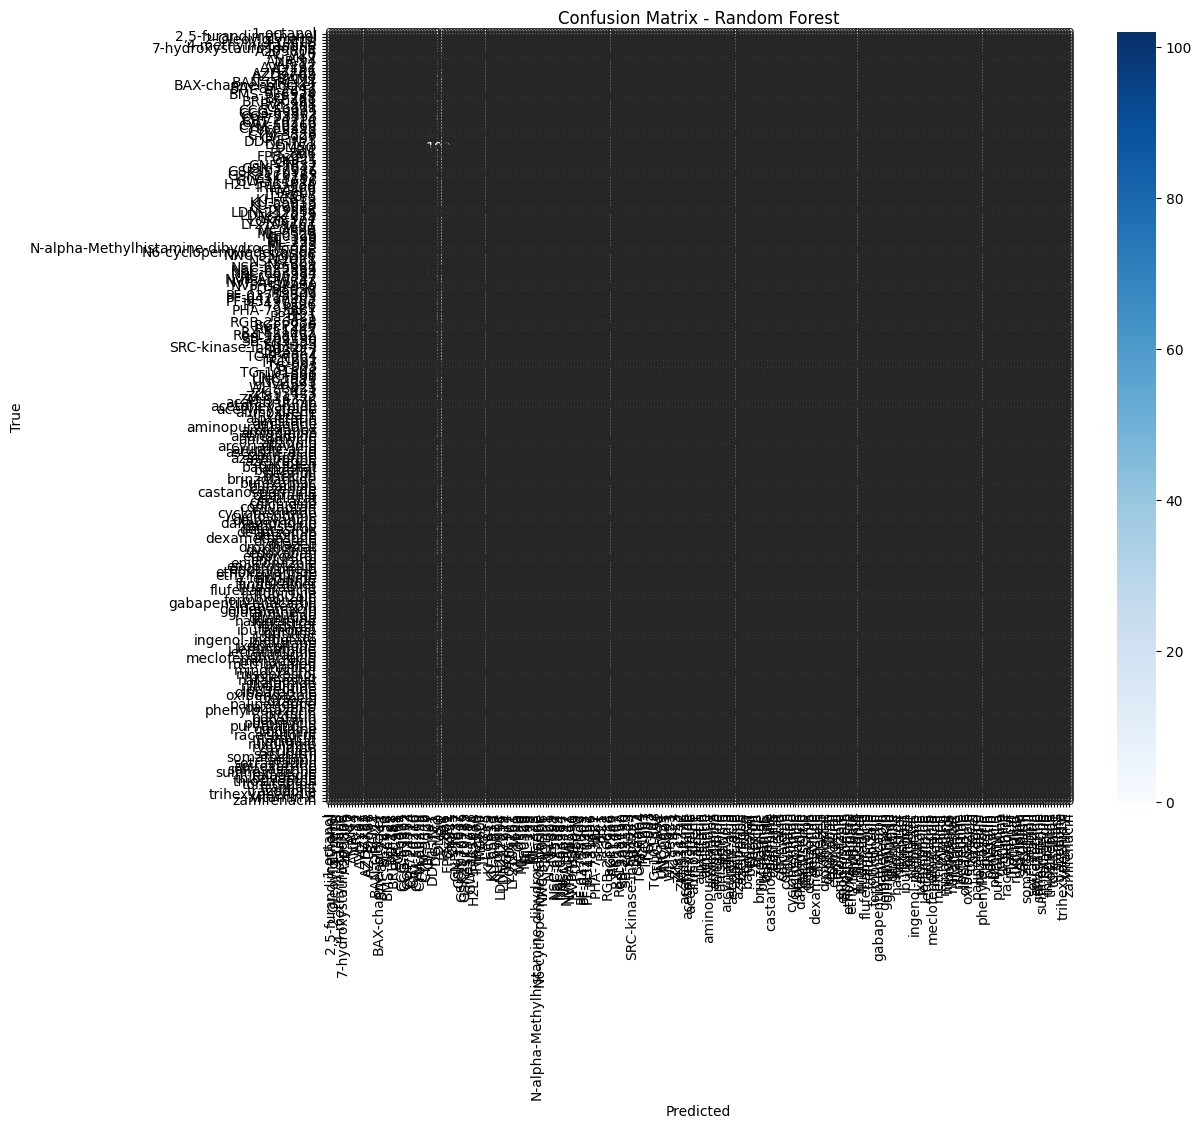

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.show()

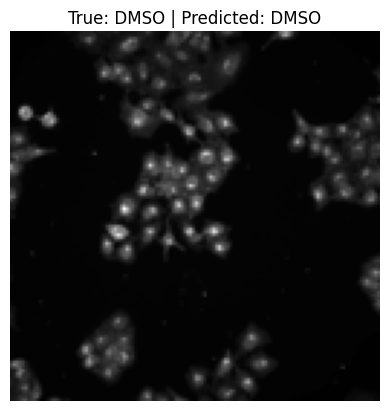

In [ ]:
num_samples = 1
indices = np.random.choice(len(X_test), num_samples, replace=False)

for idx in indices:
    img = X_test[idx].reshape(image_size)
    true_label = le.inverse_transform([y_test[idx]])[0]
    pred_label = le.inverse_transform([y_pred_rf[idx]])[0]

    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label} | Predicted: {pred_label}")
    plt.axis('off')
    plt.show()

In [ ]:
# I started with some kind of easier approches above, let's proceed with CNN which would better fit in this situation

In [ ]:
# Changed from the general code for CNN, built before.
class CellDatasetCNN(Dataset):
    def __init__(self, metadata, image_dir, transform=None):
        self.metadata = metadata.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        label = self.metadata.loc[idx, 'label']
        image_path = self.metadata.loc[idx, 'file_path']
        image = Image.open(image_path).convert('L').resize((64, 64))
        image = np.array(image, dtype=np.float32) / 255.0
        image = np.expand_dims(image, axis=0)
        image_tensor = torch.tensor(image)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return image_tensor, label_tensor

In [ ]:
train_val_metadata, test_metadata = train_test_split(merged_df, test_size=0.2, random_state=42, stratify=merged_df['label'])
train_metadata, val_metadata = train_test_split(train_val_metadata, test_size=0.25, random_state=42, stratify=train_val_metadata['label'])  # 0.25 x 0.8 = 0.2

print(f"Train set size: {len(train_metadata)}")
print(f"Validation set size: {len(val_metadata)}")
print(f"Test set size: {len(test_metadata)}")


Train set size: 1725
Validation set size: 576
Test set size: 576


In [ ]:
batch_size = 32
# We can always change the batch_size for saving time/spaces but for now I feel 32 is more common.
train_dataset_cnn = CellDatasetCNN(train_metadata, image_dir)
val_dataset_cnn = CellDatasetCNN(val_metadata, image_dir)
test_dataset_cnn = CellDatasetCNN(test_metadata, image_dir)

train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=batch_size, shuffle=False, num_workers=2)


In [ ]:
# CNN structure, pretty general
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'Using device: {device}')
    model.to(device)

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20) # making the output easier, plugging code for model from my work on computer vision.

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward and optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects / len(data_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    print(f'Best validation Acc: {best_acc:.4f}') # this should be the highest acc but just given our small sample here it might be meaningless, but it shall work well if we have enough images to train it.
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
num_classes = len(le.classes_)
model_cnn = CNNClassifier(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.0001)
model_cnn = train_model(model_cnn, criterion, optimizer, train_loader_cnn, val_loader_cnn, num_epochs=10)

Using device: cpu
Epoch 1/10
--------------------
train Loss: 5.3024 Acc: 0.1623
val Loss: 5.0985 Acc: 0.1771

Epoch 2/10
--------------------
train Loss: 5.1446 Acc: 0.1774
val Loss: 5.0598 Acc: 0.1771

Epoch 3/10
--------------------
train Loss: 5.1172 Acc: 0.1774
val Loss: 5.0330 Acc: 0.1771

Epoch 4/10
--------------------
train Loss: 5.0838 Acc: 0.1774
val Loss: 5.0208 Acc: 0.1771

Epoch 5/10
--------------------
train Loss: 5.0863 Acc: 0.1774
val Loss: 5.0088 Acc: 0.1771

Epoch 6/10
--------------------
train Loss: 5.0786 Acc: 0.1774
val Loss: 5.0043 Acc: 0.1771

Epoch 7/10
--------------------
train Loss: 5.0505 Acc: 0.1774
val Loss: 5.0211 Acc: 0.1771

Epoch 8/10
--------------------
train Loss: 5.0479 Acc: 0.1774
val Loss: 4.9747 Acc: 0.1771

Epoch 9/10
--------------------
train Loss: 5.0185 Acc: 0.1774
val Loss: 4.9637 Acc: 0.1771

Epoch 10/10
--------------------
train Loss: 5.0018 Acc: 0.1774
val Loss: 4.9426 Acc: 0.1771

Best validation Acc: 0.1771


In [ ]:
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Test Accuracy: {accuracy:.4f}')
    print('Classification Report:')
    print(classification_report(all_labels, all_preds, target_names=le.classes_))

In [ ]:
evaluate_model(model_cnn, test_loader_cnn)

Test Accuracy: 0.1771
Classification Report:
                                         precision    recall  f1-score   support

                              1-octanol       0.00      0.00      0.00         2
                    2,5-furandimethanol       0.00      0.00      0.00         2
                       2-Oleoylglycerol       0.00      0.00      0.00         2
                                 4-CMTB       0.00      0.00      0.00         2
                      4-methylhistamine       0.00      0.00      0.00         2
                 7-hydroxystaurosporine       0.00      0.00      0.00         2
                                A205804       0.00      0.00      0.00         1
                                 AC-710       0.00      0.00      0.00         2
                                   AK-7       0.00      0.00      0.00         2
                                 ANR-94       0.00      0.00      0.00         1
                                  AR-12       0.00      0.00   

In [ ]:
# In the trial below, I downsampled the merged_df and kept the number of DMSO the same as other treatements.
# In this case we'll get a much lower accuracy at the beginning given there're 250 different lables, we want the model to learn each epoch.

In [ ]:
merged_data = pd.read_csv('//content/gdrive/MyDrive/merged_data_project2.csv')
# I downsampled for DMSO for the merged data, reading in the downsampled data.

In [ ]:
# Kind of repeat the similar process just replace the dataset with the merged_data.
train_val_metadata2, test_metadata2 = train_test_split(merged_data, test_size=0.2, random_state=42, stratify=merged_data['label'])
train_metadata2, val_metadata2 = train_test_split(train_val_metadata2, test_size=0.25, random_state=42, stratify=train_val_metadata2['label'])  # 0.25 x 0.8 = 0.2

print(f"Train set size: {len(train_metadata2)}")
print(f"Validation set size: {len(val_metadata2)}")
print(f"Test set size: {len(test_metadata2)}")

batch_size = 32

train_dataset_cnn2 = CellDatasetCNN(train_metadata2, image_dir)
val_dataset_cnn2 = CellDatasetCNN(val_metadata2, image_dir)
test_dataset_cnn2 = CellDatasetCNN(test_metadata2, image_dir)

train_loader_cnn2 = DataLoader(train_dataset_cnn2, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader_cnn2 = DataLoader(val_dataset_cnn2, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_cnn2 = DataLoader(test_dataset_cnn2, batch_size=batch_size, shuffle=False, num_workers=2)

num_classes2 = len(le.classes_)
model_cnn2 = CNNClassifier(num_classes2)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model_cnn.parameters(), lr=0.0001)
model_cnn2 = train_model(model_cnn2, criterion2, optimizer2, train_loader_cnn2, val_loader_cnn2, num_epochs=10)

Train set size: 1425
Validation set size: 475
Test set size: 476
Using device: cpu
Epoch 1/10
--------------------
train Loss: 5.5221 Acc: 0.0042
val Loss: 5.5221 Acc: 0.0042

Epoch 2/10
--------------------
train Loss: 5.5217 Acc: 0.0014
val Loss: 5.5221 Acc: 0.0042

Epoch 3/10
--------------------
train Loss: 5.5224 Acc: 0.0042
val Loss: 5.5221 Acc: 0.0042

Epoch 4/10
--------------------
train Loss: 5.5220 Acc: 0.0042
val Loss: 5.5221 Acc: 0.0042

Epoch 5/10
--------------------
train Loss: 5.5221 Acc: 0.0056
val Loss: 5.5221 Acc: 0.0042

Epoch 6/10
--------------------
train Loss: 5.5218 Acc: 0.0070
val Loss: 5.5221 Acc: 0.0042

Epoch 7/10
--------------------
train Loss: 5.5224 Acc: 0.0056
val Loss: 5.5221 Acc: 0.0042

Epoch 8/10
--------------------
train Loss: 5.5225 Acc: 0.0014
val Loss: 5.5221 Acc: 0.0042

Epoch 9/10
--------------------
train Loss: 5.5222 Acc: 0.0056
val Loss: 5.5221 Acc: 0.0042

Epoch 10/10
--------------------
train Loss: 5.5217 Acc: 0.0035
val Loss: 5.5221

In [ ]:
# While this code and model should work, we really failed to have a pretty reasonable accuracy
# as with the given downsampled data, we only have 9-18 images for each treatement, which is far
# from enough for the CNN.
# Below we tried some more CNN and ResNet and see. Though the result didn't changed much.
# By here the project should be pretty solid. We made sure the code works and it can learn.
# If we're given enough images it should work fine.
# Also, we can only run 10 epoches here as I'm running in Colab so currently have no access to GPU and by here my colab already started to get very slow.
# But for CNN or similar, in this case, I might expect a dramatic change starting from around 25-30 epoches, running 50 epoches should provide a more solid result.

In [ ]:
print(metadata['Metadata_pert_iname'].value_counts())

Metadata_pert_iname
DMSO            576
AZD7762          18
buparlisib       18
thioguanine      18
CYT-997          18
               ... 
halopemide        9
quinidine         9
dyphylline        9
epothilone-b      9
aripiprazole      9
Name: count, Length: 304, dtype: int64


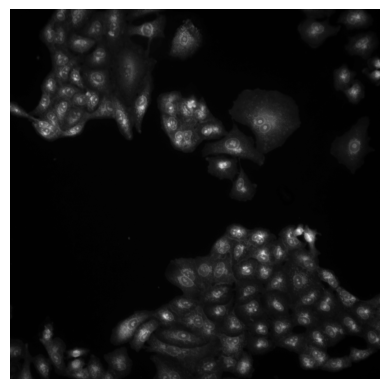

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Here I'm trying to try transform, now focusing on one sample image for parameters.
img = Image.open('/content/gdrive/MyDrive/downsampled_data/r01c01f01_median_aggregated.tiff')
plt.imshow(img, cmap='gray') # cmap='gray' help us getting higher max after transform
plt.axis('off')
plt.show()

In [ ]:
from torchvision import transforms

# I tried different parameters for more ideal normalization we want
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))
])

img_transformed = transform(img)

In [ ]:
img_transformed.max().item()

0.5607843399047852

In [ ]:
img_transformed.mean().item()

0.04106732830405235

In [ ]:
# We see the pre-normalized values are mainly 0 to 0.5608, which means that we might want to normalize with mean 0.25 and std 0.25
# We have range after normalization with parameters below and without ColorJitter as -1 to 0.8509804010391235, it looks acceptable.
# I'm considering adding ColorJitter, though it's bringing randomness and sometimes the range might drops to -1 to around 0.7 or increases to aroudn 1.13. I decreased the parameters of it trying to control.
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    #I ended up decided not to use ColorJitter as our case here doesn't seem to fit it. Though, with ColorJitter, we get roughly -1 to 1.
    transforms.ToTensor(),
    transforms.Normalize((0.25,), (0.25,))
])

img_transformed = transform(img)

In [ ]:
img_transformed

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

In [ ]:
img_transformed.max().item()

0.8509804010391235

In [ ]:
img_transformed.min().item()

-1.0

In [ ]:
img_transformed.mean().item()

-0.8440707325935364

In [ ]:
from torchvision.transforms import functional as F

class HistogramEqualization:
    def __call__(self, img):
        return F.equalize(img)

# This time when testing without normalization, we have max as 1 and min as 0.
transform = transforms.Compose([
    transforms.Grayscale(),
    HistogramEqualization(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

img_transformed = transform(img)

In [ ]:
img_transformed

tensor([[[-0.9529, -0.1216, -0.2157,  ...,  0.7961,  0.7725,  0.7647],
         [-0.9843, -0.6941, -0.3176,  ...,  0.8118,  0.7725,  0.7647],
         [-1.0000, -0.9922, -0.8667,  ...,  0.7569,  0.7333,  0.7333],
         ...,
         [-1.0000, -1.0000, -0.8118,  ...,  0.7647,  0.6863,  0.6706],
         [-1.0000, -1.0000, -0.9686,  ...,  0.7098,  0.6157,  0.4980],
         [-1.0000, -1.0000, -1.0000,  ...,  0.5922, -0.0118, -0.5216]]])

In [ ]:
img_transformed.max().item()

1.0

In [ ]:
img_transformed.min().item()

-1.0

In [ ]:
def get_prefix(filename):
    return filename.split('p01-')[0]
metadata['prefix'] = metadata['FileName_OrigRNA'].apply(get_prefix)
# Just plug out the part so that we can match with our images!

In [ ]:
import os
import pandas as pd

def get_prefixImg(filename):
    return filename.split('_')[0]
image_dir = '/content/gdrive/MyDrive/downsampled_data/'
image_files = [f for f in os.listdir(image_dir) if f.endswith('.tiff')]
image_df = pd.DataFrame({'file_path': [os.path.join(image_dir, f) for f in image_files]})
image_df['prefix'] = image_df['file_path'].apply(lambda x: get_prefixImg(os.path.basename(x)))

In [ ]:
merged_df = pd.merge(image_df, metadata, on='prefix', how='inner')
print(merged_df.head())
# Actually I'm using this merged_df created right here for the code above. I didn't run the file in sequence.
# The messy sequence was how I used when working on this project, in case for TA to test it, I'm now psating thses 3 cells above at the beginning but I actully used this area to generate the merged_df.

                                           file_path     prefix  Unnamed: 0  \
0  /content/gdrive/MyDrive/downsampled_data/r11c0...  r11c05f08        2203   
1  /content/gdrive/MyDrive/downsampled_data/r05c2...  r05c22f06        1058   
2  /content/gdrive/MyDrive/downsampled_data/r01c2...  r01c20f02         172   
3  /content/gdrive/MyDrive/downsampled_data/r12c1...  r12c17f08        2527   
4  /content/gdrive/MyDrive/downsampled_data/r11c0...  r11c02f09        2177   

                 FileName_OrigRNA  Metadata_ChannelID Metadata_Plate  \
0  r11c05f08p01-ch3sk1fk1fl1.tiff                   5     BR00116991   
1  r05c22f06p01-ch3sk1fk1fl1.tiff                   5     BR00116991   
2  r01c20f02p01-ch3sk1fk1fl1.tiff                   5     BR00116991   
3  r12c17f08p01-ch3sk1fk1fl1.tiff                   5     BR00116991   
4  r11c02f09p01-ch3sk1fk1fl1.tiff                   5     BR00116991   

  Metadata_Well  Metadata_Site  Metadata_AbsPositionZ  Metadata_PositionX  \
0           K05

In [ ]:
from google.colab import drive
import pandas as pd
output_path = '/content/gdrive/MyDrive/merged_data.csv'
merged_df.to_csv(output_path, index=False)
print(f"Data saved to {output_path}")

Data saved to /content/gdrive/MyDrive/merged_data.csv


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
merged_df['label'] = label_encoder.fit_transform(merged_df['Metadata_pert_iname'])

In [ ]:
num_classes = merged_df['label'].nunique()
print(f"Number of classes: {num_classes}")

Number of classes: 250


In [ ]:
from torchvision import transforms
from PIL import Image
import torch

# Used the same transform pipeline as what we had for example image (and since it worked!)
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transformed_images = []
labels = []

# I'm preparing transformed images though didn't actually use it later.
for idx, row in merged_df.iterrows():
    print("we're processing image:", idx, "out of", "2877")
    img = Image.open(row['file_path'])

    img_transformed = transform(img)

    transformed_images.append(img_transformed)
    labels.append(row['label'])

transformed_images_tensor = torch.stack(transformed_images)
labels_tensor = torch.tensor(labels)

print("Number of transformed images:", len(transformed_images))
print("Shape of transformed image tensor:", transformed_images_tensor.shape)

we're processing image: 0 out of 2877
we're processing image: 1 out of 2877
we're processing image: 2 out of 2877
we're processing image: 3 out of 2877
we're processing image: 4 out of 2877
we're processing image: 5 out of 2877
we're processing image: 6 out of 2877
we're processing image: 7 out of 2877
we're processing image: 8 out of 2877
we're processing image: 9 out of 2877
we're processing image: 10 out of 2877
we're processing image: 11 out of 2877
we're processing image: 12 out of 2877
we're processing image: 13 out of 2877
we're processing image: 14 out of 2877
we're processing image: 15 out of 2877
we're processing image: 16 out of 2877
we're processing image: 17 out of 2877
we're processing image: 18 out of 2877
we're processing image: 19 out of 2877
we're processing image: 20 out of 2877
we're processing image: 21 out of 2877
we're processing image: 22 out of 2877
we're processing image: 23 out of 2877
we're processing image: 24 out of 2877
we're processing image: 25 out of 2

In [ ]:
from torchvision.transforms import functional as F

class HistogramEqualization:
    def __call__(self, img):
        return F.equalize(img)
# Doing the same thing. Tried some different transforms to see if I can get better result.
transform = transforms.Compose([
    transforms.Grayscale(),
    #HistogramEqualization(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.25,))
])

In [ ]:
# This is actually my seperate approach that's why I'm importaning all libraries here.
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    merged_df,
    test_size=0.2,
    stratify=merged_df['label'],
    random_state=42
)

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'file_path']
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        label = self.dataframe.loc[idx, 'label']
        return image, label


In [ ]:
train_dataset = ImageDataset(train_df, transform=transform)
val_dataset = ImageDataset(val_df, transform=transform)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# The CNNs shared the code for training, evaluation, etc, and shared code for testing and some other parts below. So for CustomCNN, SimpleCNN, and ResNet, please make sure only the one we want to test for of these 3 is run.
num_classes = merged_df['label'].nunique()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes).to(device)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


In [ ]:
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
num_epochs = 10
import torch
# Training for CNN.
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        val_accuracy = evaluate_model(model, val_loader)
        print(f"Validation Accuracy after Epoch {epoch+1}: {val_accuracy:.4f}")

In [ ]:
# evaluation function for CNN.
def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy


In [ ]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

num_classes = merged_df['label'].nunique()
model = SimpleCNN(num_classes).to(device)

# With the same code, I tested for CNN and resnet. So avoid running the cell below if we want to test for simple CNN.

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
# trying with resnet
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

num_classes = merged_df['label'].nunique()
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(device)

cuda


In [ ]:
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Kind of repeating but just want to make sure we're on the train and val dataset we want.
train_df, val_df = train_test_split(
    merged_df,
    test_size=0.2,
    stratify=merged_df['label'],
    random_state=42
    )
unique_labels = sorted(merged_df['label'].unique())
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

train_df['mapped_label'] = train_df['label'].map(label_mapping)
val_df['mapped_label'] = val_df['label'].map(label_mapping)


class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        label = self.dataframe.iloc[idx]['mapped_label']
        return image, label

print("Train Labels:", train_df['mapped_label'].unique())
print("Validation Labels:", val_df['mapped_label'].unique())

# To be safe
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = ImageDataset(train_df, transform=transform)
val_dataset = ImageDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Train Labels: [ 38  37  39 244  36  68 133 148 249  22 186 161  65 229 207 187  32 195
 240 182  54 231  48 123 174   9   4 202 190  42 128 216 115 107  10 157
  18  23 170  90   5  16 162 239   1   3 217  53 215 219  87  82 134 105
 213  58  29  80  93  55  92 142  91  12 101 203 225  81 206 137  46  97
 173  13 223  51 120  41 222  25 112 152 185 226 113 127  73  74  43 191
 243 122   7  17  77  78  28 235  21  31  44 116  88  61 130 155 144  72
  76 149 104  62  70  95  19 111 234 184 180 245 114 106  98  30  27 147
  34 125  94 212 150 160  59 183 214 194  50 138  66 176 118 189 172 199
 136 181 154 131 100 124 171   0 109 103 241 224 117   2 145 164  96 153
 132 159 110 143   6 204 228  45 232 220 166 177  69 196 102 209 197 210
 126 200 121  64  49  83 178  15 198   8 139 163 140  99 179  57  67  89
 129  14 135 167 238 175 236 192  86 169  11  33 151  84 233 221 230  71
  26 146 247  40 156 211 218 188 165  56 246 205 119 193  20 242 201  85
  52 158  75 208  24  60  63 141  47 

In [ ]:
num_classes = len(label_mapping)  # Number of unique labels
print(f"Number of classes: {num_classes}")

Number of classes: 250


In [ ]:
# As what we did for HW C+D
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    print(f"Validation Accuracy: {val_accuracy:.4f}")

Epoch [1/10], Loss: 4.6870
Validation Accuracy: 0.1667
Epoch [2/10], Loss: 4.3846
Validation Accuracy: 0.1632
Epoch [3/10], Loss: 4.0797
Validation Accuracy: 0.1597
Epoch [4/10], Loss: 3.7458
Validation Accuracy: 0.1545
Epoch [5/10], Loss: 3.1993
Validation Accuracy: 0.1892
Epoch [6/10], Loss: 2.4527
Validation Accuracy: 0.0677
Epoch [7/10], Loss: 1.4128
Validation Accuracy: 0.0851
Epoch [8/10], Loss: 0.5685
Validation Accuracy: 0.0747
Epoch [9/10], Loss: 0.1788
Validation Accuracy: 0.1319
Epoch [10/10], Loss: 0.0432
Validation Accuracy: 0.1163


In [ ]:
test_image_path = '/content/gdrive/MyDrive/Part 2/Data/example_data/r04c08f05p01-compound-FK866.tiff'
test_image = Image.open(test_image_path)
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
test_image_tensor = transform(test_image).unsqueeze(0).to(device)  # Add batch dimension

with torch.no_grad():
    output = model(test_image_tensor)
    _, predicted_label_idx = torch.max(output, 1)

predicted_label = predicted_label_idx.item()
predicted_drug_treatment = {v: k for k, v in label_mapping.items()}.get(predicted_label, "Label not found")
print(f"Predicted Drug Treatment for the test image: {predicted_drug_treatment}")

Predicted Drug Treatment for the test image: 130


In [ ]:
predicted_drug_treatment_name = [name for name, label in label_mapping.items() if label == predicted_label]

if predicted_drug_treatment_name:
    print(f"Predicted Drug Treatment for the test image: {predicted_drug_treatment_name[0]}")
else:
    print("No matching drug treatment found for the label.")


Predicted Drug Treatment for the test image: 148


In [ ]:
rows_with_label_148 = merged_df[merged_df['label'] == 148]
print(rows_with_label_148)

                                              file_path     prefix  \
64    /content/gdrive/MyDrive/downsampled_data/r01c0...  r01c03f05   
324   /content/gdrive/MyDrive/downsampled_data/r01c0...  r01c03f03   
325   /content/gdrive/MyDrive/downsampled_data/r01c0...  r01c03f06   
875   /content/gdrive/MyDrive/downsampled_data/r01c0...  r01c03f09   
1568  /content/gdrive/MyDrive/downsampled_data/r01c0...  r01c03f07   
1584  /content/gdrive/MyDrive/downsampled_data/r01c0...  r01c03f02   
2147  /content/gdrive/MyDrive/downsampled_data/r01c0...  r01c03f01   
2159  /content/gdrive/MyDrive/downsampled_data/r01c0...  r01c03f04   
2165  /content/gdrive/MyDrive/downsampled_data/r01c0...  r01c03f08   

      Unnamed: 0                FileName_OrigRNA  Metadata_ChannelID  \
64            22  r01c03f05p01-ch3sk1fk1fl1.tiff                   5   
324           20  r01c03f03p01-ch3sk1fk1fl1.tiff                   5   
325           23  r01c03f06p01-ch3sk1fk1fl1.tiff                   5   
875        

Thus we get amlodipine.